# Think, Say, See it! Multi-model Gen AI w/ Intel HW & OpenVINO

This notebook demonstrates how to chain multiple Generative AI models together in OpenVINO with runtime in seconds on Intel CPUs and GPUs.

The pipeline is composed of four models:

1. [Whisper](https://github.com/openvinotoolkit/openvino_notebooks/blob/main/notebooks/227-whisper-subtitles-generation/227-whisper-subtitles-generation.ipynb) for speech transcription
2. RedPajama (chat version - TBD OV notebooks link) for refinement of the generated text
3. [Stable Diffusion XL](https://github.com/openvinotoolkit/openvino_notebooks/blob/main/notebooks/248-stable-diffusion-xl/248-stable-diffusion-xl.ipynb) for using the text as a prompt for image generation
4. [CLIP](https://github.com/openvinotoolkit/openvino_notebooks/blob/main/notebooks/232-clip-language-saliency-map/232-clip-language-saliency-map.ipynb) to explore interpretability of the generated image.

To explore more of the details of the models and the OpenVINO implementation, check out the individual notebooks by clicking on the above hyperlinks.

![multi_model_pipeline_TBD](https://github.com/openvinotoolkit/openvino_notebooks/assets/22090501/43ea8554-5f72-4a0a-b3e5-2c81d9b95392)


You can explore the Gradio notebook app accompanying this notebook here:TBD link

## Table of Contents


In the first part of this notebook, we'll walk through the model setup, compilation, and inference steps in detail that are necessary when you first run this notebook 
In the final section, we'll see the inference pipeline in action withg ourmodelse already compiled and ready to us from the previous step! 

## Installation and Device Selection

In [1]:
from IPython import display

In [2]:
!pip install -q "openvino-dev>=2023.0.0"
!pip install -q "python-ffmpeg<=1.0.16" "transformers" "onnx" "onnxruntime"
!pip install -q -I "git+https://github.com/garywu007/pytube.git"
!pip install -q "optimum-intel[openvino,diffusers]" "ipywidgets"
!pip install -q "diffusers>=0.16.1" "transformers>=4.28.0"
!pip install -q "git+https://github.com/huggingface/optimum-intel.git" datasets gradio

display.clear_output()

In [3]:
from pathlib import Path
from openvino.runtime import Core, Tensor
import numpy as np
import time

Let's start by selecting our device.

In [4]:
ie = Core()

In [5]:
#Select your device
import ipywidgets as widgets

device_names = [f"{device}: {ie.get_property(device, 'FULL_DEVICE_NAME')}" 
                for device in ie.available_devices]

print("Available devices: \n", device_names)

device = widgets.Dropdown(
    options=ie.available_devices,
    value='CPU',
    description='Device:',
    disabled=False,
)
device

Available devices: 
 ['CPU: Intel(R) Xeon(R) Silver 4416+', 'GPU: Intel(R) Data Center GPU Flex 170 (dGPU)']


Dropdown(description='Device:', options=('CPU', 'GPU'), value='CPU')

## Step 1: "Say it" with Whisper!

Whisper is an automatic speech recognition (ASR) system trained on 680,000 hours of multilingual and multitask supervised data collected from the web. 

### Step 1.1: Model setup
Whisper is a Transformer based encoder-decoder model, also referred to as a sequence-to-sequence model. It maps a sequence of audio spectrogram features to a sequence of text tokens. First, the raw audio inputs are converted to a log-Mel spectrogram by action of the feature extractor. Then, the Transformer encoder encodes the spectrogram to form a sequence of encoder hidden states. Finally, the decoder autoregressively predicts text tokens, conditional on both the previous tokens and the encoder hidden states.

Using the steps in [TBD.ipynb], we have our OpenVINO Whisper model files ready. We will install dependecies from the PyTorch Whisper model by downloading and pip installing the whisper repository. 

We'll then reuse the original model pipeline for audio transcribing after replacing the original models with the OpenVINO IR versions.



In [6]:
from collections import namedtuple
from functools import partial

REPO_DIR = Path("whisper")
if not REPO_DIR.exists():
    !git clone https://github.com/openai/whisper.git -b v20230124
    !cd whisper && pip install .

display.clear_output()

In [7]:
#TBD - get audio input
#For now, please use pre-recorded audio files
audio_file = Path("mountain.wav")

In [8]:
#Download whisper base model
import whisper
whisper_model = whisper.load_model("base")
whisper_model.to("cpu")
whisper_model.eval()
pass
del whisper_model.decoder
del whisper_model.encoder

In [9]:
from utils.whisper_OV_utils import *
from utils.whisper_preprocess_utils import *

Parameter = namedtuple('Parameter', ['device'])
def parameters():
    return iter([Parameter(torch.device('cpu'))])

In [11]:
ie.set_property({'CACHE_DIR': 'whisper_models/'})
whisper_model.encoder = OpenVINOAudioEncoder(ie, 'whisper_models/whisper_encoder.xml', device=device.value)
whisper_model.decoder = OpenVINOTextDecoder(ie, 'whisper_models/whisper_decoder.xml', device=device.value)
whisper_model.decode = partial(decode, whisper_model)
whisper_model.parameters = parameters
whisper_model.logits = partial(logits, whisper_model)

### Step 1.2: Run the pipeline

Let's create a function for the inference of our Whisper function and get our transcribed text using the `.transcribe()` function.

In [14]:
def whisper_inference(whisper_model, audio_file):
    audio = resample_wav(audio_file)
    t1 = time.perf_counter()
    transcription = whisper_model.transcribe(audio, beam_size=5, best_of=5, task="translate")
    t2 = time.perf_counter()
    srt_lines = prepare_srt(transcription)
    # save transcription
    with audio_file.with_suffix(".srt").open("w") as f:
        f.writelines(srt_lines)
    transcribed_txt = "".join(srt_lines)
    print(transcribed_txt)
    print(f"It took {t2 - t1}s")
    return transcribed_txt

In [15]:
widgets.Audio.from_file(audio_file, loop=False)

Audio(value=b'RIFF\x90\xac\x12\x00WAVEfmt \x10\x00\x00\x00\x01\x00\x02\x00D\xac\x00\x00\x10\xb1\x02\x00\x04\x0…

In [16]:
transcribed_txt = whisper_inference(whisper_model, audio_file)

2023-08-28 15:13:28.217006: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-28 15:13:28.218935: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-28 15:13:28.248933: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-28 15:13:28.250055: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX_VNNI AMX_TILE AMX_INT8 AMX_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-28 15:13:28.770304: W tensorflow/compiler/tf2t

 a mountain landscape in an impressionist style.
It took 2.131279820983764s


## Step 2: "Refine it" with Red Pajama-INCITE (the Chat Version)

RedPajama-INCITE is a large language model for text generation - we'll be leveraging the chat version here. 
Using Optimum-Intel, we can obtain an FP16 (TBD) precision OpenVINO model. The model will be generated if it's not already present locally.

<div class="alert alert-block alert-info">
⚠️Compilation time for the RedPajama-INCITE model can exceed 1 minute. After running the compilation block once, you do not need to run it again for inference.
</d
</div>

In [18]:
import time
from optimum.intel.openvino import OVModelForCausalLM
from transformers import AutoTokenizer
from transformers import AutoConfig

model_id = "togethercomputer/RedPajama-INCITE-Chat-3B-v1"
redpj_tokenizer = AutoTokenizer.from_pretrained("togethercomputer/RedPajama-INCITE-Chat-3B-v1")

redPJ_REPO_DIR = Path("redpajama_chat_models")
if not redPJ_REPO_DIR.exists():
    #TBD int8
    redpj_model = OVModelForCausalLM.from_pretrained(model_id, export=True, compile=False)
    redpj_model.half()
    redpj_model.save_pretrained(redPJ_REPO_DIR)

Framework not specified. Using pt to export to ONNX.
Using framework PyTorch: 1.13.1+cpu
Overriding 1 configuration item(s)
	- use_cache -> True
In-place op on output of tensor.shape. See https://pytorch.org/docs/master/onnx.html#avoid-inplace-operations-when-using-tensor-shape-in-tracing-mode
In-place op on output of tensor.shape. See https://pytorch.org/docs/master/onnx.html#avoid-inplace-operations-when-using-tensor-shape-in-tracing-mode
In-place op on output of tensor.shape. See https://pytorch.org/docs/master/onnx.html#avoid-inplace-operations-when-using-tensor-shape-in-tracing-mode
In-place op on output of tensor.shape. See https://pytorch.org/docs/master/onnx.html#avoid-inplace-operations-when-using-tensor-shape-in-tracing-mode
In-place op on output of tensor.shape. See https://pytorch.org/docs/master/onnx.html#avoid-inplace-operations-when-using-tensor-shape-in-tracing-mode
In-place op on output of tensor.shape. See https://pytorch.org/docs/master/onnx.html#avoid-inplace-operat

In [19]:
ov_config = {'PERFORMANCE_HINT': 'LATENCY', 'NUM_STREAMS': '1', "CACHE_DIR": "redpajama/"}
redpj_model = OVModelForCausalLM.from_pretrained(redPJ_REPO_DIR, device=device.value, ov_config=ov_config, use_cache=True, config=AutoConfig.from_pretrained(redPJ_REPO_DIR))

Compiling the model...


In [20]:
def redpj_inference(transcribed_txt, redpj_tokenizer, redpj_model):
    prompt = f"<human>: Write a prompt for a art generating AI model with the phrase '{transcribed_txt}' \
    Your answer should be a single, artistic sentence that adds text to the specified phrase.\n<bot>:"
    inputs = redpj_tokenizer(prompt, return_tensors='pt').to(redpj_model.device)
    input_length = inputs.input_ids.shape[1]
    t1 = time.perf_counter()
    outputs = redpj_model.generate(
        **inputs, max_new_tokens=20, do_sample=True, temperature=0.7, top_p=0.7, top_k=50, return_dict_in_generate=True
    )
    t2 = time.perf_counter()
    token = outputs.sequences[0, input_length:]
    output_str = redpj_tokenizer.decode(token)
    output_str = output_str.split(".")[0]
    print(output_str)
    print(f"It took {t2 - t1}s")
    return output_str

In [21]:
refined_txt = redpj_inference(transcribed_txt, redpj_tokenizer, redpj_model)

Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


 A mountain landscape in an impressionist style
It took 2.318883715022821s


## Step 3: "See it" with Stable Diffusion XL Refiner!

Stable Diffusion XL or SDXL is the latest image generation model that is tailored towards more photorealistic outputs with more detailed imagery and composition compared to previous Stable Diffusion models, including Stable Diffusion 2.1. 

Stable Diffusion XL can be used in a 2-stages approach: first, the base model is used to generate latents of the desired output size. In the second step, we use a specialized high-resolution model for the refinement of latents generated in the first step, using the same prompt. The Stable Diffusion XL Refiner model is designed to transform regular images into stunning masterpieces with the help of user-specified prompt text. It can be used to improve the quality of image generation after the Stable Diffusion XL Base. The refiner model accepts latents produced by the SDXL base model and text prompt for improving generated image.


We'll use Optimum-Intel to download/load our base and refiner models for the SDXL model
<div class="alert alert-block alert-info">
⚠️Compilation time for the base and refiner models can exceed 1 minute. After running the compilation block once, you do not need to run it again for inferenc”.
</d
</div>

In [22]:
from optimum.intel import OVStableDiffusionXLImg2ImgPipeline, OVStableDiffusionXLPipeline
import numpy as np

model_id = "stabilityai/stable-diffusion-xl-base-1.0"
#Load our base model for SDXL
sd_base_model_dir = Path("openvino-sd-xl-base-1.0")
ov_config = {'PERFORMANCE_HINT': 'LATENCY', 'NUM_STREAMS': '1', "CACHE_DIR": "sd_base/"}

if not sd_base_model_dir.exists():
    base = OVStableDiffusionXLPipeline.from_pretrained(model_id, compile=False, ov_config=ov_config, device=device.value)
    base.half()
    base.save_pretrained(sd_base_model_dir)
    base.compile()
else:
    base = OVStableDiffusionXLPipeline.from_pretrained(sd_base_model_dir, ov_config=ov_config, device=device.value)

Fetching 26 files:   0%|          | 0/26 [00:00<?, ?it/s]

Compiling the vae_decoder...
Compiling the unet...
Compiling the text_encoder...
Compiling the text_encoder_2...
Compiling the vae_encoder...


In [38]:
refiner_model_id = "stabilityai/stable-diffusion-xl-refiner-1.0"
#Load our refiner model for SDXL
sd_refiner_model_dir = Path("openvino-sd-xl-refiner-1.0")

ov_config = {'PERFORMANCE_HINT': 'LATENCY', 'NUM_STREAMS': '1', "CACHE_DIR": "sd_refiner/"}
if not sd_refiner_model_dir.exists():
    refiner = OVStableDiffusionXLImg2ImgPipeline.from_pretrained(refiner_model_id, export=True, ov_config=ov_config, compile=False)
    refiner.half()
    refiner.save_pretrained(sd_refiner_model_dir)
else:
    refiner = OVStableDiffusionXLImg2ImgPipeline.from_pretrained(sd_refiner_model_dir, ov_config=ov_config, device=device.value)

Compiling the vae_decoder...
Compiling the unet...
Compiling the vae_encoder...
Compiling the text_encoder_2...


In [25]:
def sdxl_refiner_inference(refined_txt, base, refiner, img_path):
    #Perform inference for the 2-stage approach for SDXL
    latents = base(refined_txt, num_inference_steps=15, height=512, width=512, 
                   generator=np.random.RandomState(314), output_type="latent").images[0]
    image = refiner(prompt=refined_txt, image=latents[None, :], num_inference_steps=15, 
                    generator=np.random.RandomState(314)).images[0]
    image.save(img_path)
    
    return image

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

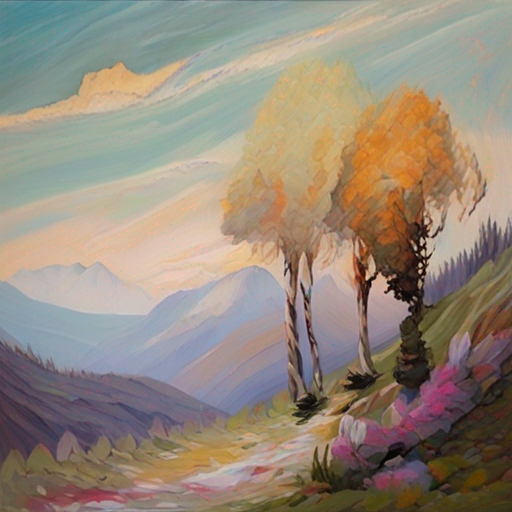

In [37]:
sdxl_refiner_inference(refined_txt, base, refiner, "sd_result.png")

## Step 4: "Understand it" with CLIP!

CLIP (Contrastive Language–Image Pre-training) is a neural network that can work with both images and texts. It has been trained to predict which randomly sampled text snippets are close to a given image, meaning that a text better describes the image. We will explore language visual saliency with CLIP; a saliency map is a visualization technique that highlights regions of interest in an image.

We'll leverage CLIP OpenVINO models that were generated in TBD.ipynb, compile the models, and perform inference on the image generated from stable diffusion.


In [27]:
from transformers import CLIPProcessor
from PIL import Image
from utils.clip_utils import *

model_checkpoint = "openai/clip-vit-base-patch16"
processor = CLIPProcessor.from_pretrained(model_checkpoint)

In [33]:
core = Core()
core.set_property({'CACHE_DIR': 'whisper_models/'})
#Load OpenVINO IRs for CLIP (our text and image models) and compile them
text_model = core.read_model("clip/clip-vit-base-patch16_text.xml")
image_model = core.read_model("clip/clip-vit-base-patch16_image.xml")
text_model = core.compile_model(model=text_model, device_name=device.value)
image_model = core.compile_model(model=image_model, device_name=device.value)

In [34]:
def clip_inference(query, img_path, text_model, image_model):
    #Run inference on the CLIP models
    image = Image.open(img_path)
    n_iters = 300
    min_crop_size = 50
    
    im_tensor = np.array(image)
    x_dim, y_dim = image.size
    text_inputs = dict(
        processor(text=[query], images=[im_tensor], return_tensors="np")
    )
    t1 = time.perf_counter()
    image_inputs = text_inputs.pop("pixel_values")
    
    text_embeds = text_model(text_inputs)[text_model.output()]
    image_embeds = image_model(image_inputs)[image_model.output()]
    
    initial_similarity = cosine_similarity(text_embeds, image_embeds)
    saliency_map = np.zeros((y_dim, x_dim))
    
    for _ in tqdm.notebook.tqdm(range(n_iters)):
        x, y, crop_size = get_random_crop_params(y_dim, x_dim, min_crop_size)
        im_crop = get_cropped_image(im_tensor, x, y, crop_size)
    
        image_inputs = processor(images=[im_crop], return_tensors="np").pixel_values
        image_embeds = image_model(image_inputs)[image_model.output()]
    
        similarity = cosine_similarity(text_embeds, image_embeds) - initial_similarity
        update_saliency_map(saliency_map, similarity, x, y, crop_size)
    t2 = time.perf_counter()
    plot_saliency_map(im_tensor, saliency_map, query, return_fig=False)
    print(f"It took {t2 - t1}s")

  0%|          | 0/300 [00:00<?, ?it/s]

It took 6.056056080968119s


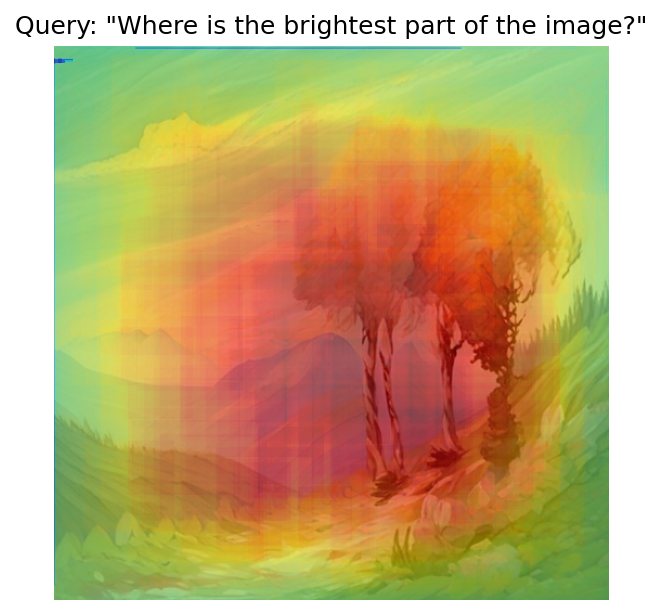

In [35]:
query = "Where is the brightest part of the image?"
clip_inference(query, "sd_result.png", text_model, image_model)

# Put it all together: Inference-only with runtimes!

Now that we've setup and compiled our models, let's look at the final pipeline for inference-only.

In [31]:
#TBD - get audio input
#For now, please use pre-recorded audio files
audio_file = Path("mountain.wav")

---Whisper---


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


 a mountain landscape in an impressionist style.
It took 0.435904776037205s
---Red Pajama-INCITE---
 A mountain landscape in an impressionist style, with soft, swirling brushstrokes, and a
It took 1.776584391016513s
---Stable Diffusion XL Refiner---


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

---CLIP---


  0%|          | 0/300 [00:00<?, ?it/s]

It took 6.226490018016193s


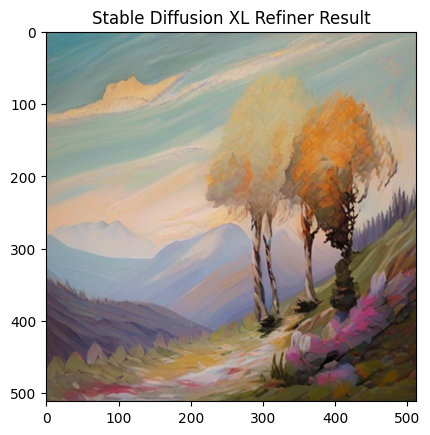

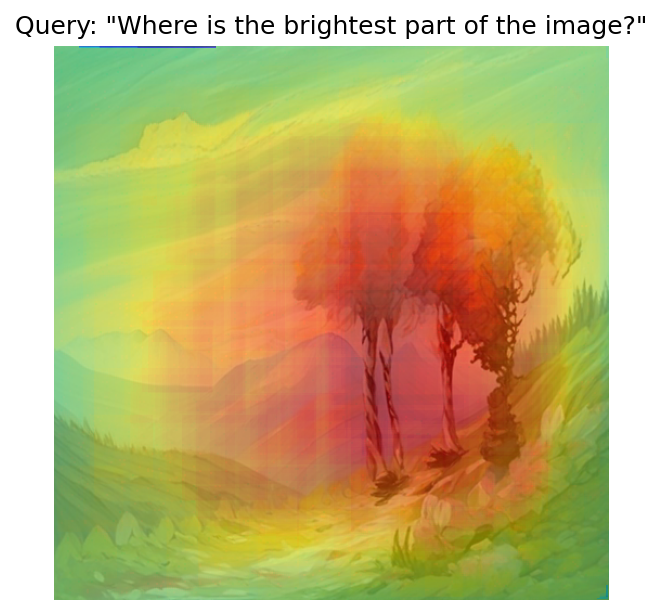

In [32]:
print("---Whisper---")
transcribed_txt = whisper_inference(whisper_model, audio_file)
print("---Red Pajama-INCITE---")
refined_txt = redpj_inference(transcribed_txt, redpj_tokenizer, redpj_model)
print("---Stable Diffusion XL Refiner---")
sd_image = sdxl_refiner_inference(refined_txt, base, refiner, "sd_result.png")
plt.figure()
plt.title("Stable Diffusion XL Refiner Result")
plt.imshow(sd_image)
print("---CLIP---")
clip_inference("Where is the brightest part of the image?", "sd_result.png", text_model, image_model)